# Calculating Coherence
## A presentation to JNCC's EO Implementation Group

__Alastair Graham__

<img src=".img/face.jpeg" alt="Me" width="150" height="150">


Freelancer, currently under contract to Oxidian (https://www.oxidian.com) for delivery of tools around the EODH (https://eodatahub.org.uk/) platform.

You can find me on [LinkedIn](https://www.linkedin.com/in/ajgwords/).

***

# Outline

* Hi there
* Requirement to calculate coherence
* Available tools
* Intro to eo-tools
  * Using data from the CDSE
  * Using data from CEDA
* Outputs and Issues 
* Possibilities on EODH

***

# The requirement
As part of the EO Data Hub (EODH) project I contacted Paula at JNCC to discuss potential needs for the platform and the tools being developed. 
Coherence was mentioned as a topic of interest so I spent some time looking into this. 

## What is coherence and why is it useful?
SAR Coherence refers to **a measure of similarity between two Synthetic Aperture Radar (SAR) images acquired over the same area at different times**. 

It is a key parameter in SAR interferometry (InSAR) and coherence analysis, providing insights into changes or stability within the observed area.

SAR coherence is mathematically defined as _the normalized cross-correlation of the complex SAR signals from two images_. The coherence depends on factors such as changes in the scene between the acquisition dates (temporal decorrelation), differences in the imaging geometry and the noise inherent to the SAR system.

### Why SAR Coherence is Useful in Habitat Analysis

SAR coherence provides valuable information for habitat monitoring and analysis. Its usefulness stems from its sensitivity to changes in the structure, moisture, and composition of vegetation, soil, and other ground surfaces. This is dependant on the imaging system collecting the data. 

1. Detecting **Change and Stability**:
   - Areas with low coherence often indicate changes such as vegetation growth, deforestation, flooding, or urban development.
   - In habitats, it can help identify seasonal changes, disturbances, or degradation over time.
   - High coherence suggests minimal change, useful for identifying stable habitats or regions of consistent land cover .

2. Mapping **Vegetation Dynamics**:
   - Linked to (1): Temporal coherence variations correlate with vegetation density and structure, providing insights into biomass estimation and forest health.

3. **Differentiating Land Covers**:
   - Different land cover types (e.g., forests, wetlands, grasslands) exhibit characteristic coherence signatures due to their unique scattering properties.

4. **Flood and Wetland** Monitoring:
   - Coherence can be used to monitor hydrological changes in wetlands and floodplains, as water surfaces cause a significant reduction in coherence.

SAR coherence serves as a powerful tool in remote sensing for understanding and managing ecosystems.

***

# Available tools 
## (and more importantly, ones we can use)

The EODH link meant that we needed open tooling. There are commercial software packages that can calculate coherence but they are expensive and generally graphical in nature. I was also looking for CLI tools.

* __SNAP Graph Processing Tool (GPT)__ 
  * GPT is the command-line powerhouse of ESA SNAP, enabling efficient, large-scale processing workflows tailored for remote sensing and SAR applications. It’s essential for automating and scaling tasks that would otherwise be tedious in the GUI.
  * Workflows are written in XML files that describe the sequence of operations.
  * Powerful and scalable, and suitable for HPC clusters.
* __PyGMTSAR__
  * Advanced InSAR analysis for researchers, requiring technical expertise.
  * A Python-based extension of GMTSAR (Generic Mapping Tools for SAR), focused on SAR interferometry and deformation analysis.
  * Automates and streamlines workflows for interferogram generation, coherence analysis, and time-series analysis.
  * Less user-friendly for beginners; requires familiarity with Linux and command-line tools.
* __eo-tools__
  * Lightweight and flexible, ideal for developers working in Python with cloud or custom workflows.
  * Designed for flexibility in handling EO data from diverse sources.
  * Scalable for use in cloud or local environments
  * __Simple and efficient for batch processing__ or integrating SAR data into larger workflows.
  * Highly customizable for developers.
  * Lacks some advanced features for SAR interferometry.

***

# Introduction to eo-tools

EO-Tools is a relatively new Python toolbox for processing EO data, specifically designed for Sentinel-1 and -2 images, as well as Digital Elevation Models (DEMs). It provides tools for searching, downloading, and processing satellite data, enabling users to perform interferometric processing, terrain correction, and visualisation. The toolbox supports:
* Sentinel-1 Synthetic Aperture Radar (SAR) processing: including InSAR analysis, and 
* Sentinel-2 optical data processing, such as tile merging and exporting color composites. 

Additionally, EO-Tools offers utilities for DEM acquisition, catalog searches, and interactive map visualisations.

The software is available in two installation versions: via Conda package and via Docker (which adds advanced interactive visualisation capabilities via TiTiler). The Conda package is recommended for most users and can be installed within a virtual environment using Conda or Mamba. The Docker version is better suited for advanced users who require extended functionalities, including the legacy SNAP-based processor. 

EO-Tools integrates well with Jupyter notebooks which helps with interactive analysis. It provides Cloud Optimized GeoTIFF (COG) outputs and supports interactive mapping through Folium. The documentation offers detailed tutorials and API references for both beginners and experienced users. EO-Tools simplifies certain aspects of satellite data processing, making it an accessible solution for a variety of users. 
***

## Walk through

This demo is based on the how-to on the eo-tools website. There are a couple of bits that have been reworked or added to.

## Setup
### conda environment reqts
It is recommended to first create a conda environment to avoid package conflicts. You need to have one of conda / mamba / micromamba  installed.

Then the package can be installed with these commands (replace conda by mamba or micromamba if needed):

`conda env create -n eo_tools` - replace `conda` with the correct command if using one of the other two installers

`conda activate eo_tools`

`conda install conda-forge::eo-tools` 

If using the EODH AppHub then these instructions help explain how to create a cond environment:
https://help.jasmin.ac.uk/docs/interactive-computing/creating-a-virtual-environment-in-the-notebooks-service/

### auth reqts
If using the Copernicus Data Space Ecosystem a free account needs to be created at https://dataspace.copernicus.eu/
The credentials need to be configured as explained here https://eodag.readthedocs.io/en/stable/getting_started_guide/configure.html

If using EODH then data can be downloaded from the CEDA catalogue without an account. To use the AppHub or workflow runner you would require an account from https://test.eodatahub.org.uk/contact/ 

In [10]:

from itertools import combinations

import os
import eo_tools
import geopandas as gpd
import matplotlib.pyplot as plt
import rioxarray as riox
#import shapely
from eo_tools.S1.process import process_insar
from eodag import EODataAccessGateway
from shapely.geometry import shape

# credentials need to be stored in the following file (see EODAG docs)
confpath = "~/.config/eodag/eodag.yml"
dag = EODataAccessGateway()
# make sure cop_dataspace will be used
dag.set_preferred_provider("cop_dataspace")
#logging.basicConfig(level=logging.INFO)

In [11]:
# Set download dirs
data_dir = "/home/al/Downloads/jncc_eotools" # set this to work for you

# example AOI around Thetford
file_aoi = f"{data_dir}/thetfordaoi.geojson"
shp2 = gpd.read_file(file_aoi).geometry[0]

In [12]:
# Calculate bbox
xmin, ymin, xmax, ymax = shp2.bounds
bbox = {
    "lonmin": xmin,
    "latmin": ymin,
    "lonmax": xmax,
    "latmax": ymax
}

print(bbox)

{'lonmin': 0.105734423810487, 'latmin': 52.44639077957711, 'lonmax': 0.685652665706907, 'latmax': 52.55804798614935}


In [13]:
# Run search

search_criteria = {
    "productType": "S1_SAR_SLC",
    "start": "2023-09-03",
    "end": "2023-09-17",
    "geom": bbox,
}

results, _ = dag.search(**search_criteria)

In [14]:
eo_tools.util.explore_products(results, shp2)

In [15]:
# Find overlaps
data = []
for item in results:
    id = item.properties["id"]
    geom = shape(item.geometry)
    data.append({"id": id, "geometry": geom})

gdf = gpd.GeoDataFrame(data, crs="EPSG:4326")  # Assuming WGS84

# 98% overlap
threshold = 0.98

overlaps = []
for (idx1, row1), (idx2, row2) in combinations(gdf.iterrows(), 2):
    intersection = row1["geometry"].intersection(row2["geometry"])
    if not intersection.is_empty:
        # Calculate overlap ratio as the area of intersection divided by the area of the smaller polygon
        overlap_ratio = intersection.area / min(
            row1["geometry"].area, row2["geometry"].area
        )
        if overlap_ratio >= threshold:
            overlaps.append((row1["id"], row2["id"], overlap_ratio))

overlap_ids = [entry[:-1] for entry in overlaps]
overlap_ids

[('S1A_IW_SLC__1SDV_20230904T174209_20230904T174236_050181_060A2D_E88F',
  'S1A_IW_SLC__1SDV_20230916T174209_20230916T174236_050356_061016_8033')]

# Using CDSE

In [20]:
# Data from CDSE

ids = ["S1A_IW_SLC__1SDV_20230904T174209_20230904T174236_050181_060A2D_E88F",
      "S1A_IW_SLC__1SDV_20230916T174209_20230916T174236_050356_061016_8033"
      ]

# Set directories
primary_dir = f"{data_dir}/cdse/{ids[0]}.zip"
secondary_dir = f"{data_dir}/cdse/{ids[1]}.zip"
outputs_prefix = f"{data_dir}/cdse/res/test-full-processor"

In [9]:
# Download overlapping products
# Only run if you need the data. Files are 8GB and downloading is usually throttled.

to_dl = [it for it in results if it.properties["id"] in ids]
print(f"{len(to_dl)} products to download")
dag.download_all(to_dl, outputs_prefix=data_dir, extract=False)

2 products to download


Downloaded products:   0%|          | 0/2 [00:00<?, ?product/s]

0.00B [00:00, ?B/s]

0.00B [00:00, ?B/s]

['/home/al/Documents/EODH/Code/eodh-tests/jncc/~/Downloads/jncc_eotools/S1A_IW_SLC__1SDV_20230904T174209_20230904T174236_050181_060A2D_E88F.zip',
 '/home/al/Documents/EODH/Code/eodh-tests/jncc/~/Downloads/jncc_eotools/S1A_IW_SLC__1SDV_20230916T174209_20230916T174236_050356_061016_8033.zip']

In [18]:
# Check data files
import os

def list_files_recursive(directory=data_dir):
    file_list = []
    
    for root, _, files in os.walk(directory):
        for file in files:
            file_list.append(os.path.relpath(os.path.join(root, file), directory))
    
    return file_list

# Example usage
files = list_files_recursive()

print("Files in directory and subdirectories:")
for file in files:
    print(file)


Files in directory and subdirectories:
thetfordaoi.geojson
thetford2aoi.geojson
cdse/S1A_IW_SLC__1SDV_20230916T174209_20230916T174236_050356_061016_8033.zip
cdse/S1A_IW_SLC__1SDV_20230904T174209_20230904T174236_050181_060A2D_E88F.zip


In [22]:
out_dir = process_insar(
    dir_prm=primary_dir,
    dir_sec=secondary_dir,
    outputs_prefix=outputs_prefix,
    aoi_name=None,
    shp=shp2,
    pol="vv",
    subswaths=["IW1", "IW2", "IW3"],
    write_coherence=True,
    write_interferogram=True,
    write_primary_amplitude=True,
    write_secondary_amplitude=False,
    apply_fast_esd=True,
    dem_upsampling=1.8,
    dem_force_download=False,
    dem_buffer_arc_sec=40,
    boxcar_coherence=[3, 3],
    filter_ifg=True,
    multilook=[1, 4],
    warp_kernel="bicubic",
    clip_to_shape=True,
)

# Outputs

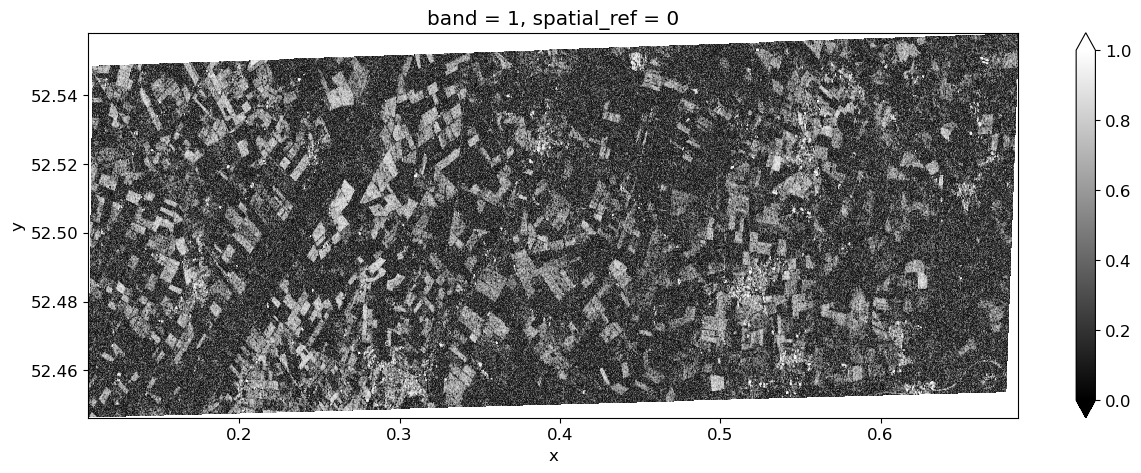

In [33]:
# Visualise coherence
arr_coh = riox.open_rasterio(f"{out_dir}/coh_vv.tif", masked=True)[0]
arr_coh.plot.imshow(aspect=3, size=5, vmin=0,vmax=1, cmap="gray")

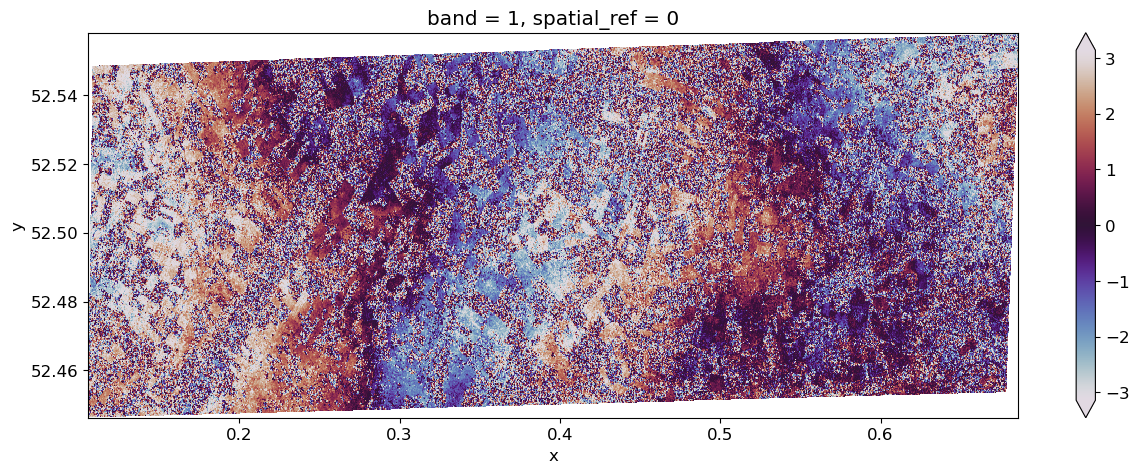

In [32]:
# Visualise interferrogram
arr_phi = riox.open_rasterio(f"{out_dir}/phi_vv.tif", masked=True)[0]
arr_phi.plot.imshow(aspect=3, size=5, vmin=-3.14,vmax=3.14, cmap="twilight")

# Possibilities on the EODH

The EODH platform is being designed to allow external connections, to run Python code through the Jupyter-based AppHub and to enable developers to run EO Application Packages.

  * AppHub - the AppHub is a JupyterHub installation that allows registered users to run Python code (most often via Jupyter Notebooks).
  * EOAP - requires 'packages' created in Common Workflow Language (CWL) and are then run via APIs or a QGIS plugin.

We have proven that it is possible to process coherence using CWL but it is more intuitive to use Python.